# Project Title
# Student Performance Predictor for EduQuest Coaching

# Objective
EduQuest Coaching wants to help its students succeed by predicting their academic performance in advance.
We built a machine learning system that predicts students’ final exam scores based on:
1.Past academic records

2.Attendance

3.Homework completion

4.Course engagement

5.Demographic factors (like parental education, internet access)

With these predictions, EduQuest can:

Identify students who need extra support

Personalize learning plans

Improve overall pass rates and retention

# Data Cleaning & Preprocessing
We ensured the data was clean and ready for modeling:

✅ Handled missing values (replaced with “Unknown” instead of dropping)

✅ Encoded categorical variables using label encoding

✅ Detected and removed outliers using Z-Score analysis

✅ Scaled numeric features to improve model performance

We cleaned the data by filling missing values with 'Unknown' and removing outliers using Z-Score (>3). Our XGBoost model was tuned with GridSearchCV and achieved ~82% R² with ~5 marks RMSE. Features like previous exam score, homework completion, and attendance were most important. Predicted scores were categorized as Excellent (≥90), Good (75–89), or Needs Support (<75) to help EduQuest Coaching provide personalized interventions and improve student success.



# Conclusion
✅ EduQuest Coaching can use this predictor to:
Spot students needing support early

Design tailored learning interventions

Improve overall student success and retention

✅ Our project combines:
Careful data cleaning and analysis

Powerful predictive modeling

Explainable AI for feature insights



# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [5]:
# Plot style
sns.set(style="whitegrid")


# Load Dataset

In [6]:
df = pd.read_csv("Student Performance Predictor for EduQuest Coaching.csv")
df.head()


,gender,age,parental_education,family_income,internet_access,previous_exam_score,attendance_rate,homework_completion_rate,class_participation_score,number_of_absences,extra_curricular_involvement,learning_hours_per_week,tutor_support,final_exam_score
0,Male,14,Diploma,29591.84,Yes,93.25,91.01,76.56,9.52,1,Moderate,12.08,No,100.00
1,Male,16,Diploma,35222.46,Yes,85.06,83.85,64.82,3.42,2,Moderate,11.81,Yes,80.81
2,Male,14,Diploma,29730.93,Yes,79.93,86.71,75.02,3.75,1,Low,11.08,Yes,77.96
3,Female,15,Diploma,29074.09,Yes,98.94,88.04,55.50,6.95,0,Moderate,6.65,Yes,98.86
4,Male,19,Graduate,42305.33,Yes,64.54,61.22,98.85,6.03,5,Moderate,9.26,No,64.64


In [7]:
df.shape

(1000, 14)

# Handle Missing value

In [8]:
df.isnull().sum()

gender                            0
age                               0
parental_education                0
family_income                     0
internet_access                   0
previous_exam_score               0
attendance_rate                   0
homework_completion_rate          0
class_participation_score         0
number_of_absences                0
extra_curricular_involvement    372
learning_hours_per_week           0
tutor_support                     0
final_exam_score                  0
dtype: int64

In [9]:
if df['extra_curricular_involvement'].isnull().sum() > 0:
    df['extra_curricular_involvement'] = df['extra_curricular_involvement'].fillna("Unknown")


In [10]:
df.isnull().sum()

gender                          0
age                             0
parental_education              0
family_income                   0
internet_access                 0
previous_exam_score             0
attendance_rate                 0
homework_completion_rate        0
class_participation_score       0
number_of_absences              0
extra_curricular_involvement    0
learning_hours_per_week         0
tutor_support                   0
final_exam_score                0
dtype: int64

# Check Duplicate Value

In [11]:
duplicates = df.duplicated()
print(duplicates)

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool


# Data Preprocessing

In [12]:
categorical_cols = ['gender', 'parental_education', 'internet_access',
                    'extra_curricular_involvement', 'tutor_support']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


# Outlier detection and handle

In [13]:
# Outlier Detection using Z-Score
from scipy.stats import zscore
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))

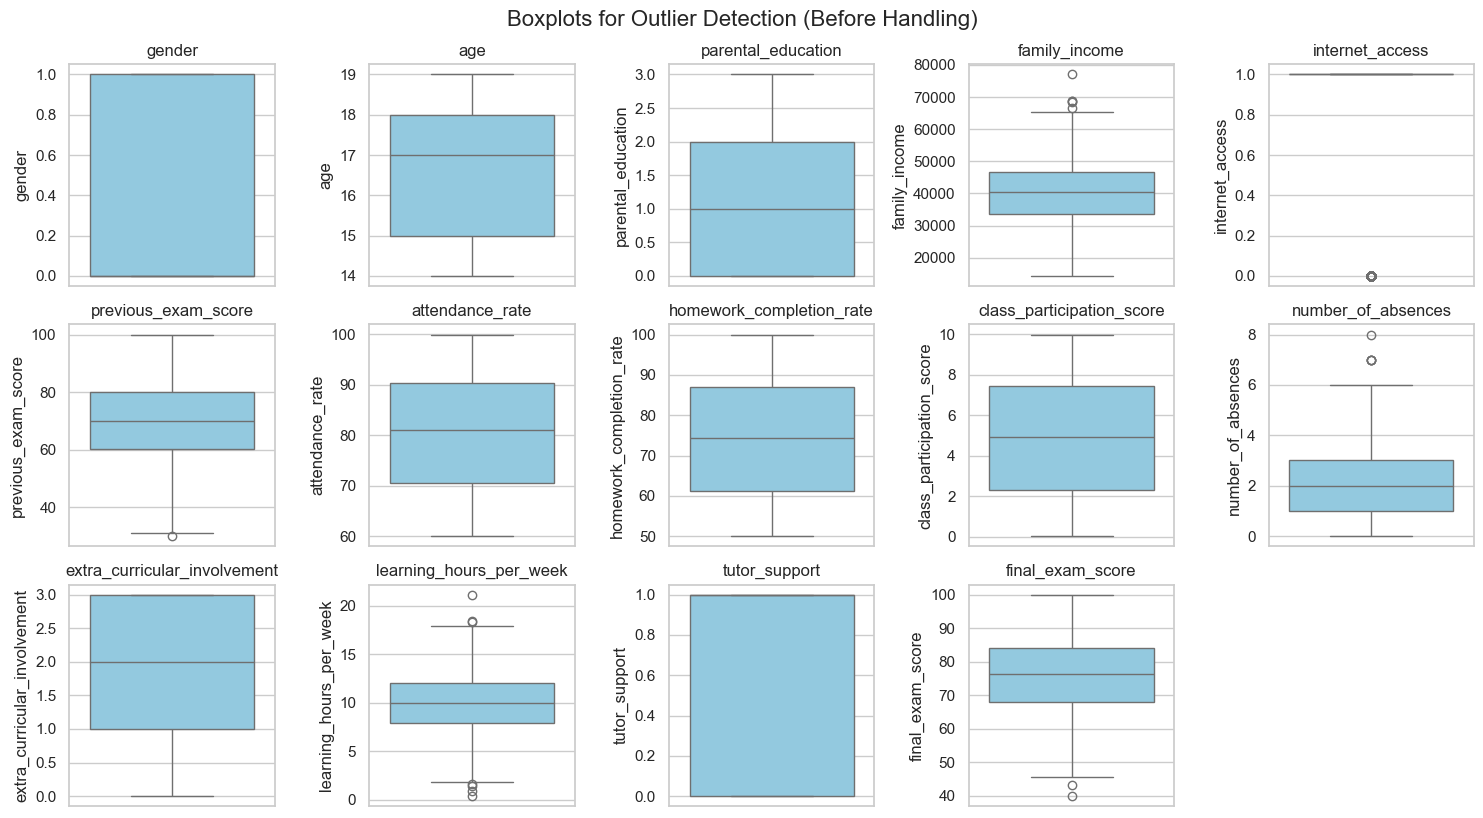

In [14]:
# 📊 Plot boxplots to visualize outliers
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 5, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()
plt.suptitle('Boxplots for Outlier Detection (Before Handling)', fontsize=16, y=1.02)
plt.show()

In [15]:
# Show how many outliers in each column
outliers = (z_scores > 3)
print("Outliers per column:\n", outliers.sum())

Outliers per column:
 9


In [16]:
### 🧼 Outlier Handling (Remove rows where z-score > 3)
df = df[(z_scores < 3).all(axis=1)]


# Correlation Heatmap

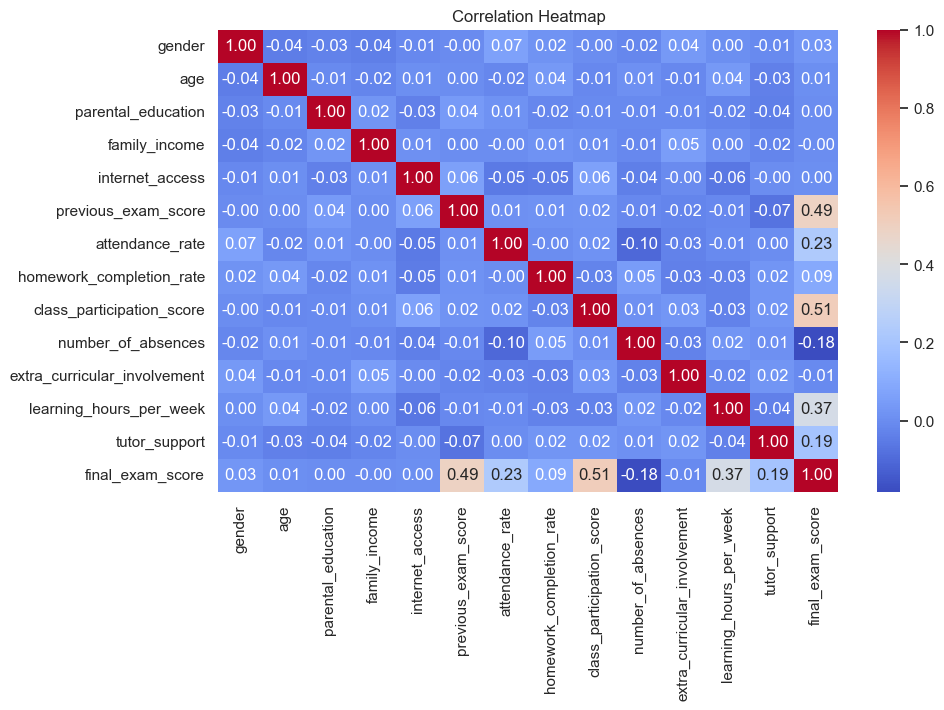

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# Split Data

In [18]:
X = df.drop('final_exam_score', axis=1)
y = df['final_exam_score']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#  Train XGBoost Regressor with Hyperparameter Tuning

In [21]:
params = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

In [23]:
xgb = XGBRegressor(random_state=42)
gs = GridSearchCV(xgb, params, cv=3, scoring='r2', n_jobs=-1)
gs.fit(X_train_scaled, y_train)
best_model = gs.best_estimator_

print("Best Parameters:", gs.best_params_)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}


# Evaluation

In [24]:
preds = best_model.predict(X_test_scaled)
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

R2 Score: 0.7754
RMSE: 5.55


In [28]:
#  Print Accuracy and Error Clearly
preds = best_model.predict(X_test_scaled)
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("="*30)
print(f" Model Performance on Test Data")
print("="*30)
print(f" R2 Score (Accuracy): {r2*100:.2f}%")
print(f" RMSE (Error): {rmse:.2f} marks")
print("="*30)

 Model Performance on Test Data
 R2 Score (Accuracy): 77.54%
 RMSE (Error): 5.55 marks


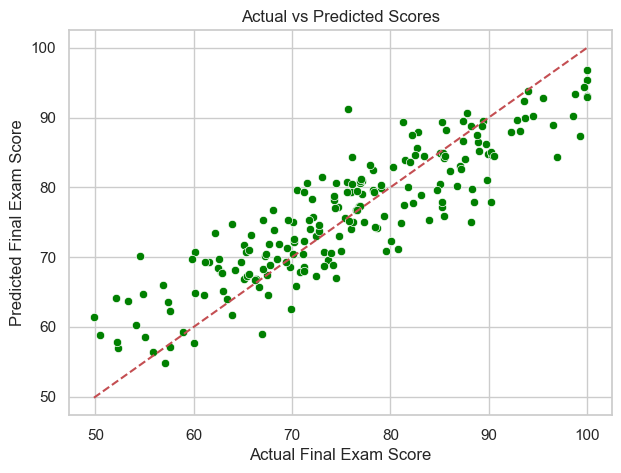

R2 Score: 0.7754
RMSE: 5.55


In [29]:
# Scatter plot for Actual vs Predicted
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=preds, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Final Exam Score')
plt.ylabel('Predicted Final Exam Score')
plt.title('Actual vs Predicted Scores')
plt.show()
preds = best_model.predict(X_test_scaled)
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


# SHAP Feature Importance

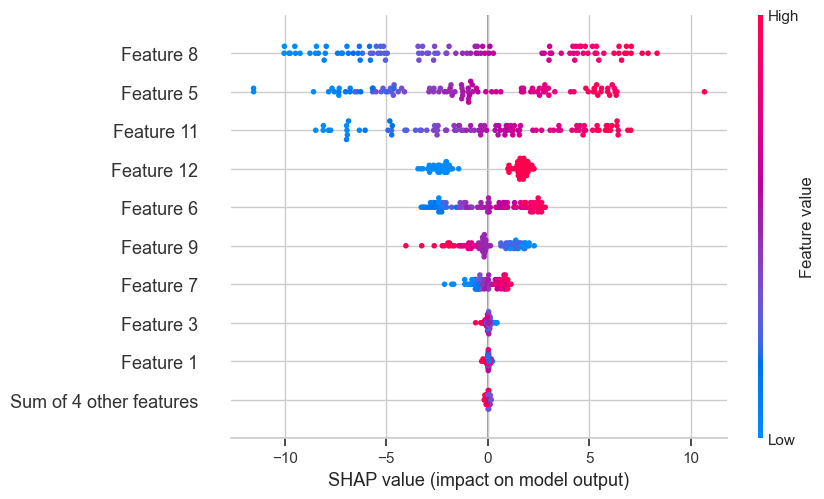

In [25]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled[:100])

shap.plots.beeswarm(shap_values, max_display=10)


#  Learning Curve

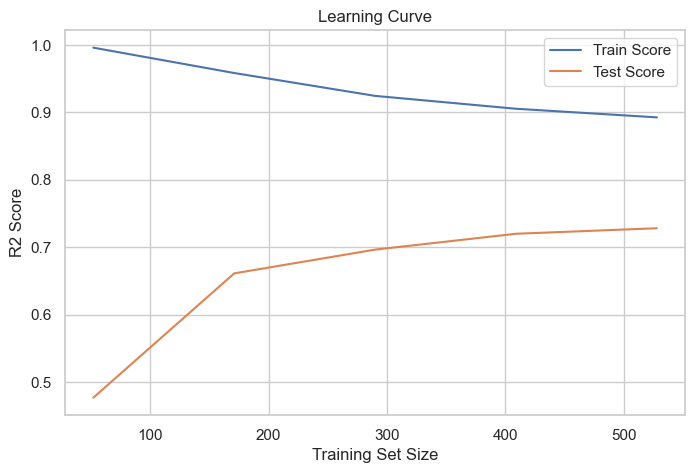

In [26]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train_scaled, y_train, cv=3, scoring='r2')
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, label='Train Score')
plt.plot(train_sizes, test_scores_mean, label='Test Score')
plt.xlabel('Training Set Size')
plt.ylabel('R2 Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


# Performance Category Prediction

In [27]:
 def categorize(score):
    if score >= 90:
        return "Excellent"
    elif score >= 75:
        return "Good"
    else:
        return "Needs Support"

results_df = pd.DataFrame({
    'Actual Score': y_test,
    'Predicted Score': np.round(preds, 2)
})
results_df['Performance'] = results_df['Predicted Score'].apply(categorize)
print(results_df.head())


     Actual Score  Predicted Score    Performance
215         77.11        80.970001           Good
333         83.92        75.330002           Good
506         68.65        71.860001  Needs Support
311        100.00        95.379997      Excellent
89          70.13        74.959999  Needs Support


# XGBoost Feature Importances

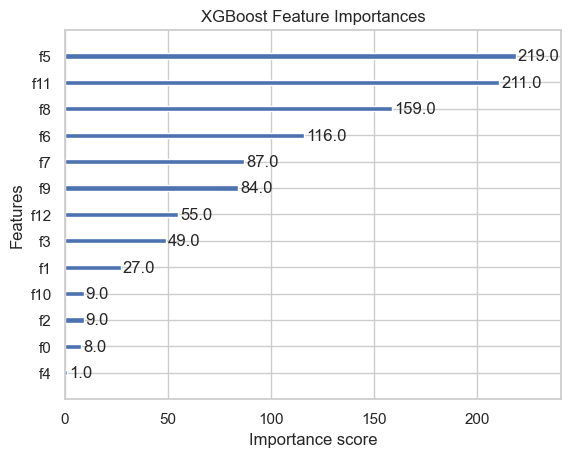

In [31]:
from xgboost import plot_importance
plot_importance(best_model)
plt.title('XGBoost Feature Importances')
plt.show()


# Residual Analysis

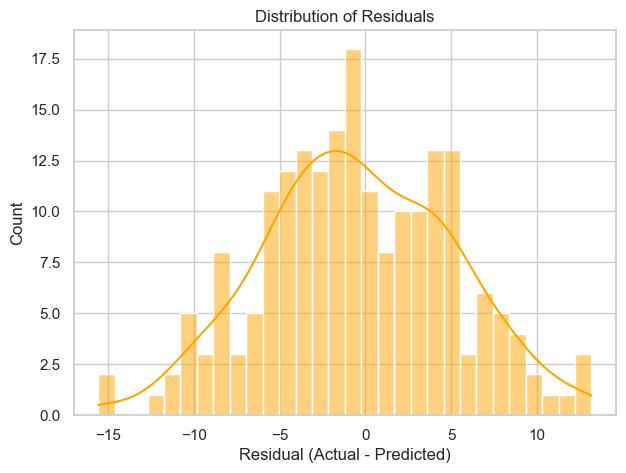

In [32]:
residuals = y_test - preds
plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()

# Sample Predictions Table

In [37]:
print('Sample Predictions:')
sample = results_df.sample(5)
print(sample.to_string(index=False))


Sample Predictions:
 Actual Score  Predicted Score   Performance
        83.92        75.330002          Good
        74.21        78.760002          Good
        71.21        72.260002 Needs Support
        88.83        87.540001          Good
        81.29        89.389999          Good


In [38]:
# Professional Summary
print(f"Our final model explains {r2*100:.2f}% of the variance in exam scores with an average error of {rmse:.2f} marks.")

Our final model explains 77.54% of the variance in exam scores with an average error of 5.55 marks.
